## 0. Import Libraries

In [21]:
from datetime import datetime, timedelta
from glob import glob

import numpy as np
import geopandas
from shapely.geometry import mapping
import xskillscore
from netCDF4 import Dataset
import pandas as pd
import pyproj
import rioxarray
import salem
import xarray as xr
from shapely.geometry import mapping
import matplotlib.patheffects as pe
from matplotlib.patches import Patch


import cartopy
import matplotlib.pyplot as plt
import proplot
from matplotlib.colors import BoundaryNorm, ListedColormap
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from dea_tools.spatial import xr_vectorize, xr_rasterize
from wrf import ll_to_xy

import warnings
warnings.filterwarnings('ignore')

## 1. Simulation Data

### 1.1 Data Options

In [3]:
run_season = 'spring'
variable = 'PRCP'
general_path = 'data'

# ensemble members
micro_options = [
    'lin',
    'thompson',
    'wsm6'
]

luse_options = [
    'urban',
    'nourban'
]

# data path
data_path = glob(fr'{general_path}/*{run_season}**{variable}*')

In [4]:
data_path

['data/spring_lin_nourban_PRCP_wrfout_d03_2014-05-05.nc',
 'data/spring_lin_urban_PRCP_wrfout_d03_2014-05-05.nc',
 'data/spring_thompson_nourban_PRCP_wrfout_d03_2014-05-05.nc',
 'data/spring_thompson_urban_PRCP_wrfout_d03_2014-05-05.nc',
 'data/spring_wsm6_nourban_PRCP_wrfout_d03_2014-05-05.nc',
 'data/spring_wsm6_urban_PRCP_wrfout_d03_2014-05-05.nc']

### 1.2 Open Data

In [5]:
# open data
dt = xr.open_mfdataset(data_path,
                       concat_dim='ens')[variable]

# instead of 201 grid we want 200 grid in each direction
dt = dt.isel(south_north=slice(0,200),
             west_east=slice(0,200))

# assign projection and dim info
dt = dt.rio.write_crs(dt.attrs['pyproj_srs'])
dt = dt.rio.set_spatial_dims(x_dim='west_east',
                             y_dim='south_north')

### 1.3 Define Members

In [6]:
# ensemble member list
ensemble_members = list(dt.ens.values)

# urban and nourban members
urban_members = [ens for ens in ensemble_members if not 'nourban' in ens ]
nourban_members = [ens for ens in ensemble_members if 'nourban' in ens ]

### 1.4 Ensemble Mean For Urban

In [7]:
dt_urban_ens = dt.sel(ens=urban_members).mean(dim='ens')[:21]

In [8]:
xy_index_data = Dataset(r'../../../Desktop/ankara/geo_em.d03.nc')

In [9]:
xy_index_data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    TITLE: OUTPUT FROM GEOGRID V3.8.1
    SIMULATION_START_DATE: 0000-00-00_00:00:00
    WEST-EAST_GRID_DIMENSION: 202
    SOUTH-NORTH_GRID_DIMENSION: 202
    BOTTOM-TOP_GRID_DIMENSION: 0
    WEST-EAST_PATCH_START_UNSTAG: 1
    WEST-EAST_PATCH_END_UNSTAG: 201
    WEST-EAST_PATCH_START_STAG: 1
    WEST-EAST_PATCH_END_STAG: 202
    SOUTH-NORTH_PATCH_START_UNSTAG: 1
    SOUTH-NORTH_PATCH_END_UNSTAG: 201
    SOUTH-NORTH_PATCH_START_STAG: 1
    SOUTH-NORTH_PATCH_END_STAG: 202
    GRIDTYPE: C
    DX: 1000.0
    DY: 1000.0
    DYN_OPT: 2
    CEN_LAT: 39.744022
    CEN_LON: 32.406708
    TRUELAT1: 39.825
    TRUELAT2: 39.825
    MOAD_CEN_LAT: 39.82501
    STAND_LON: 32.512
    POLE_LAT: 90.0
    POLE_LON: 0.0
    corner_lats: [38.83776  40.63643  40.638573 38.839848 38.8377   40.636364 40.63852
 38.839806 38.83327  40.640923 40.643074 38.835358 38.8332   40.64086
 40.643013 38.835297]
    corner_lo

In [10]:
dt_urban_ens

<xarray.DataArray 'PRCP' (time: 21, south_north: 200, west_east: 200)>
dask.array<getitem, shape=(21, 200, 200), dtype=float32, chunksize=(21, 200, 200), chunktype=numpy.ndarray>
Coordinates:
    lat          (south_north, west_east) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lon          (south_north, west_east) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    xtime        (time) datetime64[ns] dask.array<chunksize=(21,), meta=np.ndarray>
  * time         (time) datetime64[ns] 2014-05-05 ... 2014-05-05T20:00:00
  * west_east    (west_east) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
  * south_north  (south_north) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
    spatial_ref  int64 0

## 2. IMERG Data

In [11]:
# define general path to datasets
data_source = 'imerg'
imerg_var = 'precipitationUncal'
general_path = f'data/observation/{data_source}/*20140505*'

# get individual data links
data_links = glob(general_path)
imerg = xr.open_mfdataset(data_links)

# adjust imerg units and turn it from 30 mins interval to 1 hour sums
imerg = imerg.resample(time = '1H').sum()[imerg_var]
imerg = imerg.transpose('time', 'lat', 'lon')[:21]

In [12]:
imerg

<xarray.DataArray 'precipitationUncal' (time: 21, lat: 60, lon: 190)>
dask.array<getitem, shape=(21, 60, 190), dtype=float32, chunksize=(1, 60, 190), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2014-05-05 ... 2014-05-05T20:00:00
  * lon      (lon) float32 26.05 26.15 26.25 26.35 ... 44.65 44.75 44.85 44.95
  * lat      (lat) float32 36.05 36.15 36.25 36.35 ... 41.65 41.75 41.85 41.95

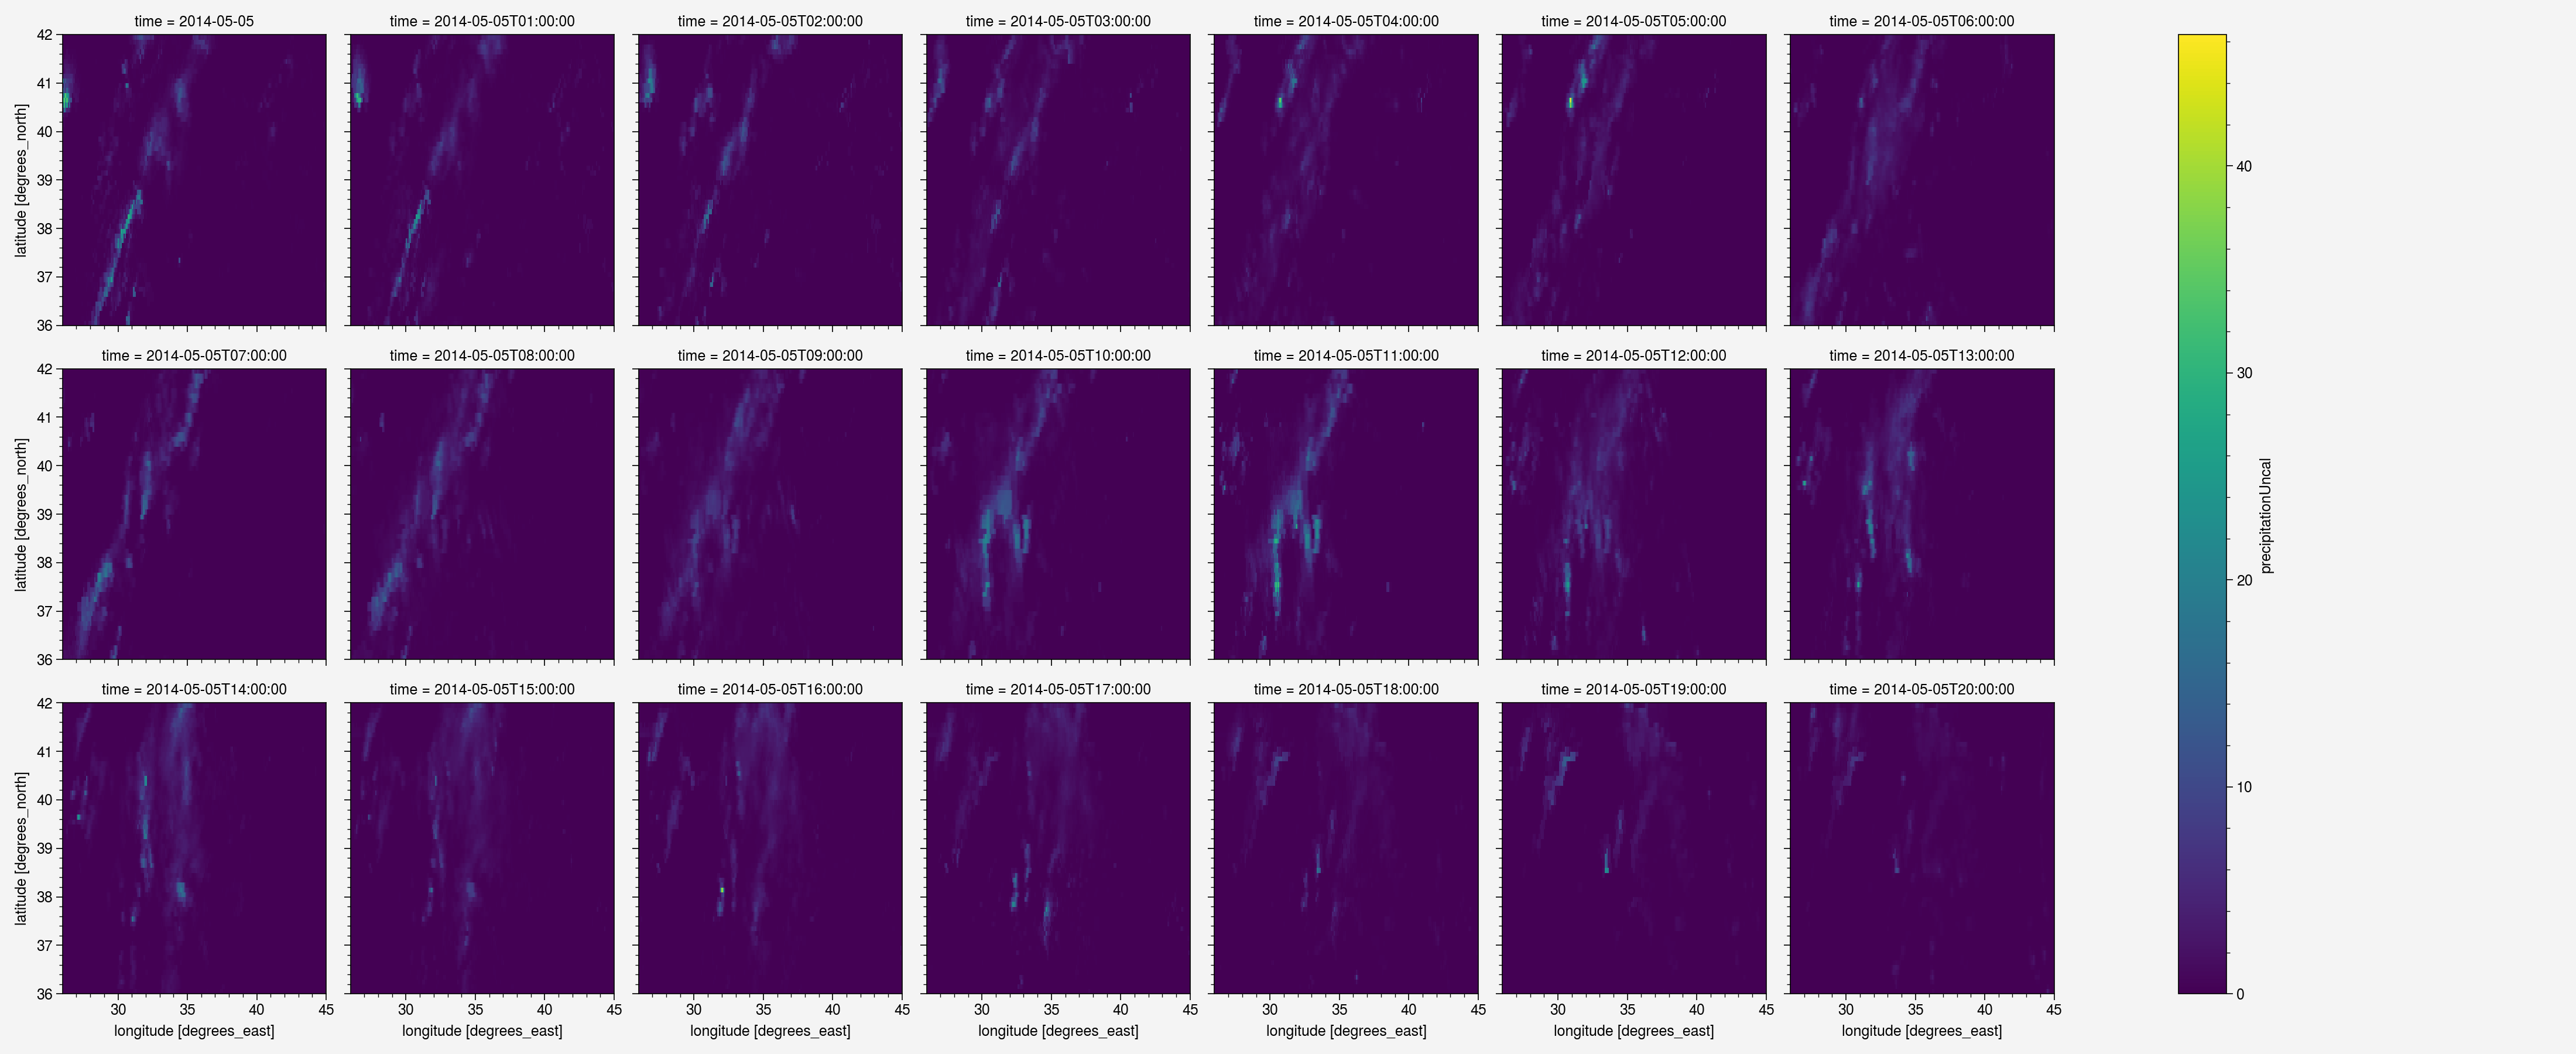

In [34]:
imerg.plot(col='time', col_wrap=7)

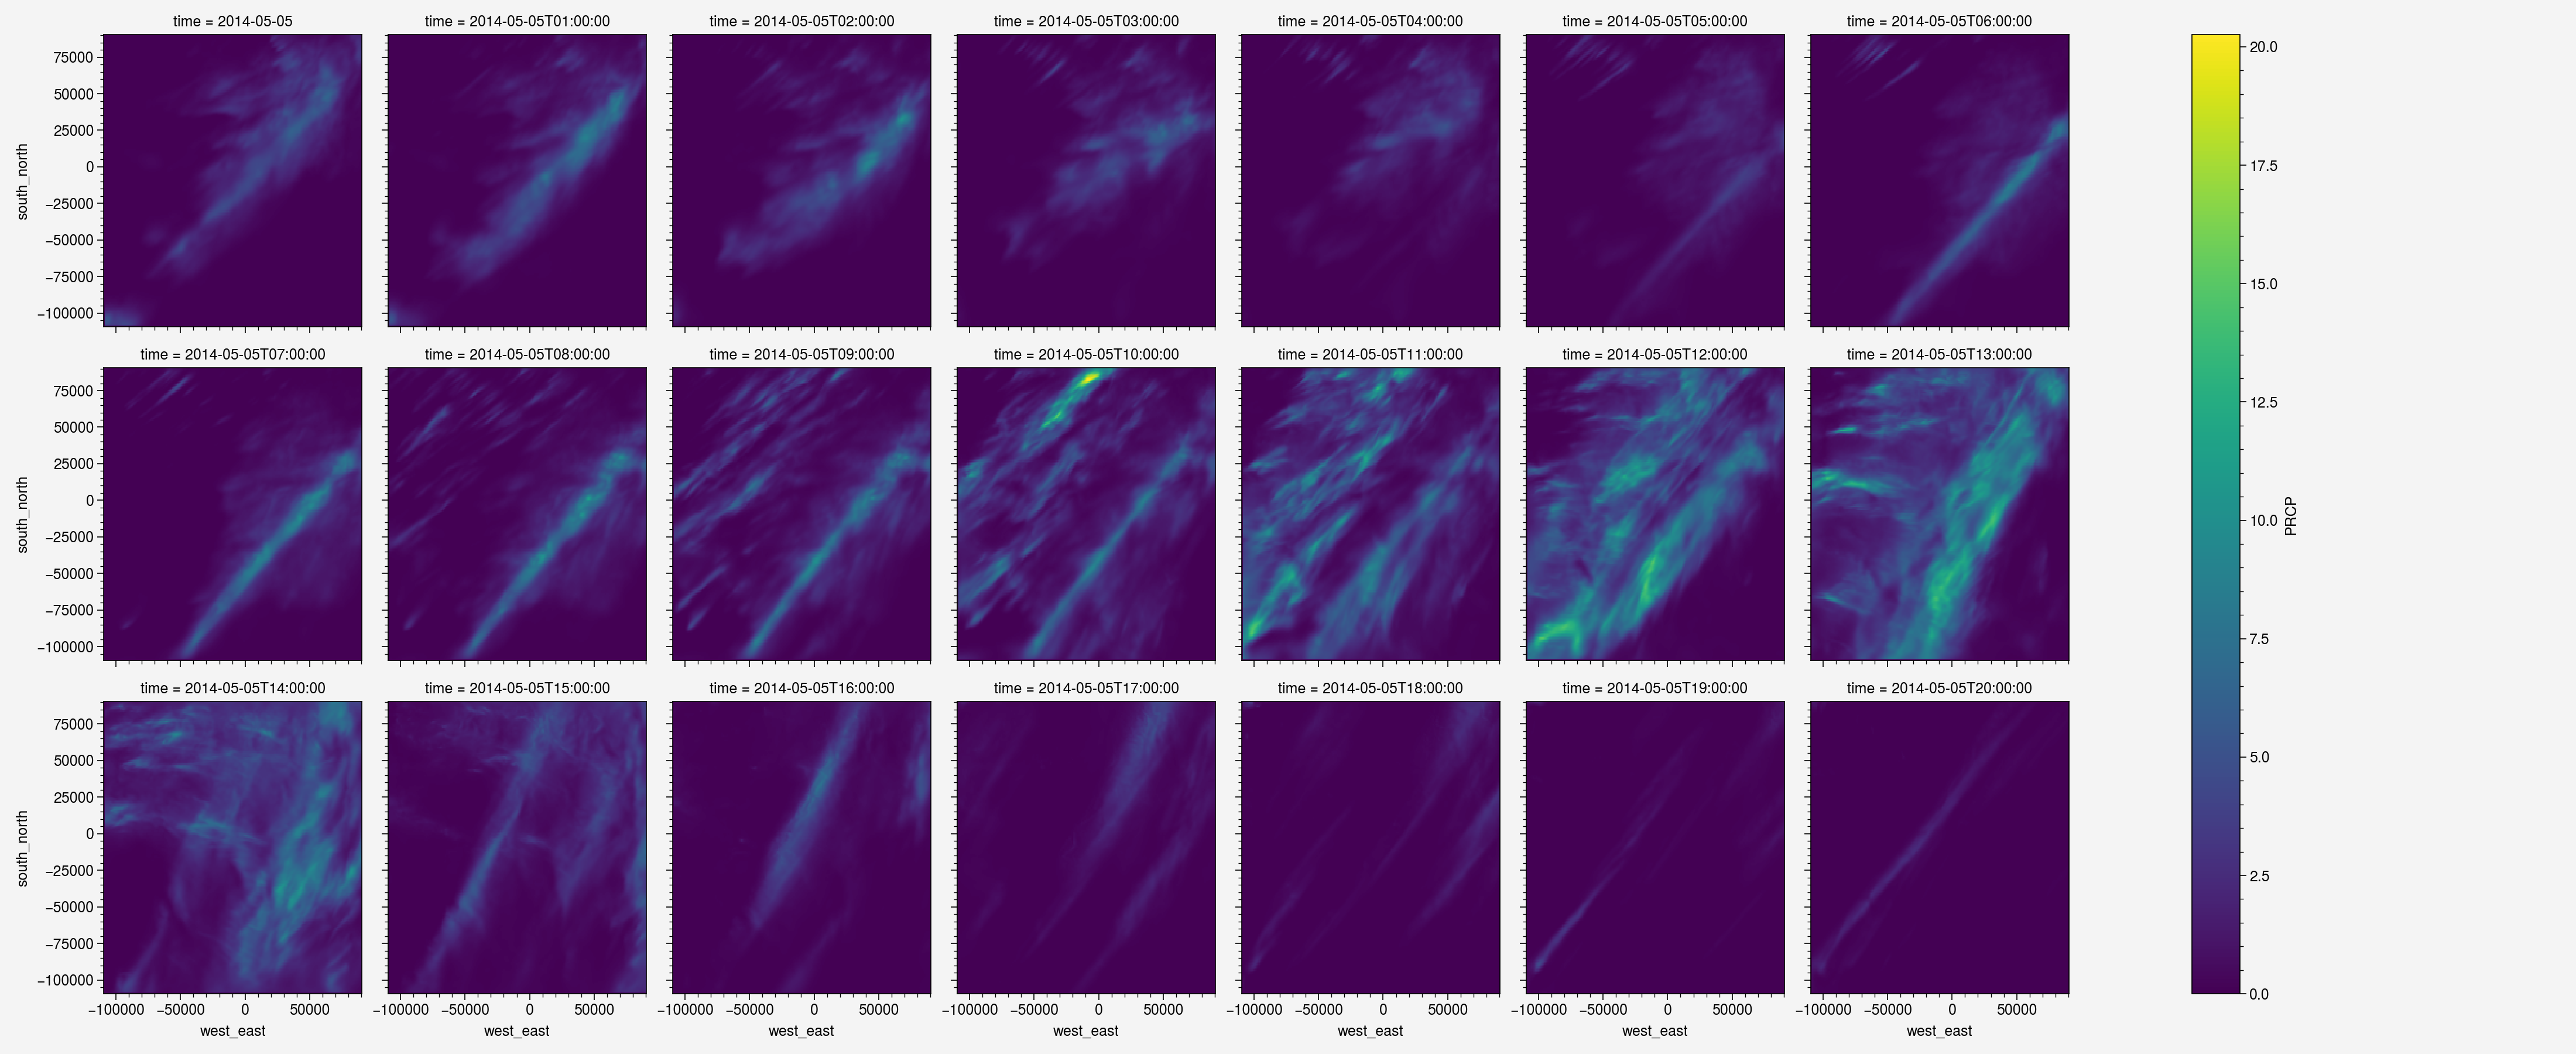

In [35]:
dt_urban_ens.plot(col='time', col_wrap=7)

## 3. Observation (MGM) Data

In [36]:
def adjust_station_data(dt, start_year, end_year):
    
    # dates queried: 2011 to 2018
    date_query = list(range(start_year, end_year+1))
    dt = dt.query(f'Year in {date_query}').reset_index(drop=True)

    # change -999 to np.nan
    dt = dt.where(dt!=-999, np.nan)
    
    # int to str
    dt[['Year', 'Month', 'Day', 'Hour']] = dt[['Year', 'Month', 'Day', 'Hour']].astype(str)

    # add new datetime col
    dt['Date'] = pd.to_datetime(dt[['Year', 'Month', 'Day', 'Hour']])
    
    return dt

def retrieve_station(province):
    """
    Adjusts and retrieves station dataset
        of corresponding province.
    """
    
    data_source = 'mgm'
    var_name = 'P' # possible: T, P
    unit = 'mm'

    # define general path to datasets
    general_path = f'data/observation/{data_source}/{var_name}.xlsx'

    # get individual data links
    data_links = glob(general_path)

    # open dataframe
    dt = pd.read_excel(data_links[0])
    
    # set attributes
    dt.attrs['data-source'] = data_source
    dt.attrs['var-name'] = var_name
    dt.attrs['unit'] = unit
    dt.attrs['province'] = province
    
    return dt

def get_station_metadata(province):
    
    data_source = 'mgm'
    dt = pd.read_excel(fr'data/observation/{data_source}/locations.xlsx')
    dt.attrs['data-source'] = 'station metadata'
    dt.attrs['province'] = province
    dt.attrs['height-unit'] = 'm'
    
    return dt

In [59]:
province = 'ankara'
observation = adjust_station_data(retrieve_station(province), 2014, 2015)
observation = observation.query('Year=="2014" and Month=="5" and Day=="5"').reset_index(drop=True).loc[:20]
observation = observation.drop(columns = ['Year', 'Month', 'Day', 'Hour'])

In [60]:
observation

,17130,17134,17137,17651,17664,17679,17680,17715,17728,17729,...,18240,18241,18242,18243,18244,18250,18256,18257,18903,Date
0,0.9,0.8,2.8,0.4,0.4,0.0,0.0,3.2,1.2,0.6,...,1.3,0.1,1.8,2.0,3.0,0.9,0.6,0.8,2.7,2014-05-05 00:00:00
1,1.6,1.4,4.6,0.0,0.0,0.0,0.0,3.6,0.2,1.0,...,1.1,0.0,1.8,2.0,2.0,1.6,1.2,2.8,1.8,2014-05-05 01:00:00
2,0.9,2.4,1.8,2.6,0.0,0.8,0.0,1.6,0.2,1.4,...,0.3,0.0,0.8,1.1,0.4,0.9,1.8,1.8,0.3,2014-05-05 02:00:00
3,2.3,2.0,2.6,0.4,1.6,0.2,0.0,1.8,0.4,0.6,...,1.8,0.1,1.3,3.0,1.1,2.4,2.6,1.4,0.6,2014-05-05 03:00:00
4,0.2,0.4,0.8,0.0,2.2,0.0,0.8,1.4,0.8,0.4,...,0.8,1.2,1.3,0.9,1.2,0.1,0.0,0.5,0.6,2014-05-05 04:00:00
5,0.1,0.0,0.6,0.0,1.8,0.0,0.8,0.8,0.0,0.6,...,0.3,0.6,1.4,0.8,0.3,0.1,0.0,0.1,0.0,2014-05-05 05:00:00
6,0.4,0.0,1.2,0.4,3.2,0.0,2.2,0.6,0.2,0.8,...,0.1,0.4,1.0,0.6,1.6,0.3,0.3,1.2,2.7,2014-05-05 06:00:00
7,1.6,1.4,1.6,0.4,2.8,0.4,2.0,1.8,1.8,0.6,...,2.1,0.9,3.5,2.3,2.1,1.5,1.5,1.5,3.3,2014-05-05 07:00:00
8,2.4,2.2,1.2,3.8,5.2,1.8,0.8,0.8,1.4,0.0,...,4.4,2.8,1.6,4.2,5.0,2.3,2.6,2.4,4.8,2014-05-05 08:00:00
9,2.8,2.4,3.2,2.6,1.6,1.0,1.2,3.4,2.6,0.4,...,9.2,4.7,2.1,8.7,2.3,2.9,2.6,2.5,1.5,2014-05-05 09:00:00


In [39]:
observation.columns

Index([ 17130,  17134,  17137,  17651,  17664,  17679,  17680,  17715,  17728,
        17729,  17731,  17733,  17759,  17987,  18045,  18046,  18072,  18073,
        18074,  18075,  18076,  18077,  18078,  18240,  18241,  18242,  18243,
        18244,  18250,  18256,  18257,  18903, 'Date'],
      dtype='object')

In [40]:
metadata = get_station_metadata(province)
metadata = metadata[metadata['station'].isin(observation.columns)].reset_index(drop=True)
metadata

,station,y,x
0,17130,39.9727,32.8637
1,17134,39.8032,32.8434
2,17137,39.7985,32.9716
3,17651,39.1525,32.1283
4,17664,40.4729,32.6441
5,17679,40.1733,31.3320
6,17680,40.1608,31.9172
7,17715,39.9200,33.2125
8,17728,39.5834,32.1624
9,17729,39.5546,33.1089


## 4. Point Data From Spatial Data

In [41]:
metadata

,station,y,x
0,17130,39.9727,32.8637
1,17134,39.8032,32.8434
2,17137,39.7985,32.9716
3,17651,39.1525,32.1283
4,17664,40.4729,32.6441
5,17679,40.1733,31.3320
6,17680,40.1608,31.9172
7,17715,39.9200,33.2125
8,17728,39.5834,32.1624
9,17729,39.5546,33.1089


In [42]:
def assign_date_info(from_, to_):
    to_['Date'] = from_['Date']
    
    return to_

### 4.1 WRF Data

In [61]:
xy_locations = np.zeros((32, 2), dtype=int)

for i in range(len(metadata)):
    x,y = ll_to_xy(xy_index_data, metadata.iloc[i, 1], metadata.iloc[i, 2])
    xy_locations[i, 0] = y
    xy_locations[i, 1] = x

In [62]:
xy_locations

array([[125, 139],
       [107, 137],
       [106, 148],
       [ 34,  76],
       [181, 120],
       [148,   9],
       [146,  58],
       [120, 169],
       [ 82,  79],
       [ 79, 160],
       [ 13, 188],
       [ 85, 123],
       [100,  98],
       [133, 175],
       [132,  85],
       [118, 138],
       [138, 134],
       [159, 124],
       [120, 150],
       [182, 105],
       [139, 186],
       [152,  87],
       [ 79,  57],
       [144, 160],
       [195, 108],
       [160, 151],
       [132, 141],
       [128, 115],
       [125, 139],
       [113, 135],
       [ 66, 109],
       [137, 117]])

In [63]:
dt_wrf_point = {}

for i in range(len(metadata)):
    
    dt_ = dt_urban_ens.isel(south_north=xy_locations[i, 0], west_east=xy_locations[i, 1])
    dt_wrf_point[metadata.iloc[i, 0]] = list(dt_.values)

In [64]:
wrf_pd = pd.DataFrame(dt_wrf_point)
wrf_pd = assign_date_info(observation, wrf_pd)

In [65]:
wrf_pd#.plot()

,17130,17134,17137,17651,17664,17679,17680,17715,17728,17729,...,18240,18241,18242,18243,18244,18250,18256,18257,18903,Date
0,4.433156,2.634079,1.912804,0.130521,0.697276,0.000000,0.285446,0.998627,1.164066,0.000215,...,5.197819,0.035543,2.000534,5.355174,3.567952,4.433156,3.340891,0.567397,1.536997,2014-05-05 00:00:00
1,3.472061,4.520878,3.568350,1.083910,0.511721,0.000081,0.063191,2.183692,0.666431,0.000465,...,4.834097,0.054370,1.229066,3.365407,2.538772,3.472061,5.266606,2.205822,0.582661,2014-05-05 01:00:00
2,0.793550,3.122597,7.623762,0.002535,0.321417,0.000158,0.000553,4.686941,2.118873,0.460090,...,2.154733,0.164342,0.449652,2.433234,2.007475,0.793550,1.949675,2.150257,0.385251,2014-05-05 02:00:00
3,1.979435,1.552333,2.529942,0.000004,0.358910,0.000287,0.000000,1.503927,1.424601,0.330498,...,2.348834,0.240886,0.695584,4.050056,3.513888,1.979435,2.529143,0.301410,1.021220,2014-05-05 03:00:00
4,1.054953,0.515983,0.785418,0.009296,0.353768,0.000000,0.000000,0.347397,0.205635,0.718936,...,2.872110,0.164737,1.451527,3.194122,4.288472,1.054953,0.792291,0.124480,1.522267,2014-05-05 04:00:00
5,0.872796,0.849116,1.407218,0.056764,0.042008,0.000000,0.000000,1.165177,0.024949,1.357073,...,1.761189,0.027602,1.255095,2.188007,2.063094,0.872796,1.228280,0.087985,0.462062,2014-05-05 05:00:00
6,1.283034,1.419155,1.891199,0.435585,0.006652,0.000246,0.000000,1.624013,0.000254,1.320474,...,1.134549,0.082351,0.839422,1.709834,0.897846,1.283034,2.045615,0.939558,0.323220,2014-05-05 06:00:00
7,1.168007,1.943333,4.571818,1.367866,0.017466,0.000178,0.000000,4.851274,0.000029,1.416642,...,0.744437,0.106287,0.726585,1.299295,0.934719,1.168007,2.033557,3.765579,0.417239,2014-05-05 07:00:00
8,0.751070,2.418180,8.546561,1.674983,1.466002,0.206461,0.188051,6.242453,0.059256,1.446667,...,0.856712,0.472452,0.413559,1.345873,0.588537,0.751070,2.010289,6.175920,0.372524,2014-05-05 08:00:00
9,1.087505,3.999569,8.206024,2.788390,0.538999,0.001191,0.782450,4.902327,0.445978,1.220327,...,1.155173,2.850736,0.480160,1.928213,0.330252,1.087505,2.425680,9.428281,0.370550,2014-05-05 09:00:00


### 4.2 IMERG data

In [66]:
dt_imerg_point = {}

for i in range(len(metadata)):
    
    dt_ = imerg.sel(lat=metadata.iloc[i, 1], lon=metadata.iloc[i, 2], method='nearest')
    dt_imerg_point[metadata.iloc[i, 0]] = list(dt_.values)

In [67]:
imerg_pd = pd.DataFrame(dt_imerg_point)
imerg_pd = assign_date_info(observation, imerg_pd)

In [68]:
imerg_pd#.plot()

,17130,17134,17137,17651,17664,17679,17680,17715,17728,17729,...,18240,18241,18242,18243,18244,18250,18256,18257,18903,Date
0,4.103548,4.800413,5.797129,1.385386,0.933805,0.013306,0.350000,4.173281,8.857958,4.663283,...,4.037073,0.540000,2.708879,3.901416,6.500134,4.103548,4.800413,0.890000,4.866392,2014-05-05 00:00:00
1,4.358397,4.352469,3.858993,2.954354,0.000000,0.128590,0.061661,4.653176,3.575125,2.582898,...,2.966272,0.000000,1.088614,3.023454,3.494836,4.358397,4.352469,1.852924,2.691786,2014-05-05 01:00:00
2,4.050000,5.230000,4.150000,10.955448,0.000000,1.016222,0.051608,5.060000,6.051686,1.250000,...,0.890000,0.000000,0.230000,2.480000,1.630000,4.050000,5.230000,7.090000,0.410000,2014-05-05 02:00:00
3,1.512255,3.611351,5.555581,7.801331,0.545895,1.015865,1.267878,3.156085,2.166440,0.772174,...,1.031911,0.469747,0.786449,1.100466,0.910032,1.512255,3.611351,7.892502,0.796360,2014-05-05 03:00:00
4,1.411739,1.543689,3.053802,1.977569,1.246937,0.184375,0.957112,1.757259,0.755184,1.793756,...,0.904367,0.794437,0.764221,0.754578,0.987040,1.411739,1.543689,5.311291,1.162885,2014-05-05 04:00:00
5,2.566727,1.543851,3.040359,0.206387,0.429134,0.352622,0.778430,1.895006,1.143776,3.425112,...,2.219251,0.143105,1.659334,1.387444,0.394368,2.566727,1.543851,0.700476,1.726110,2014-05-05 05:00:00
6,2.021734,2.446193,2.749289,3.246719,2.474473,0.603291,5.601266,2.925833,5.305227,3.978299,...,4.632157,2.145449,3.552294,3.018543,2.375870,2.021734,2.446193,2.725471,2.818382,2014-05-05 06:00:00
7,2.084043,2.022650,1.108478,9.536574,1.254888,0.233295,6.809472,2.326538,8.744149,0.452835,...,4.955435,1.295241,3.574743,2.773071,3.126704,2.084043,2.022650,2.813661,2.665789,2014-05-05 07:00:00
8,3.117787,2.653066,2.832479,10.542812,7.059816,0.745515,2.433140,2.606713,4.959780,1.029189,...,2.451066,3.988061,3.123977,3.822867,8.020548,3.117787,2.653066,6.334555,6.621581,2014-05-05 08:00:00
9,2.880021,2.119786,0.696097,5.180260,4.819580,1.384710,2.326477,1.202703,2.630373,0.554733,...,2.154335,5.384847,3.290481,5.447888,4.980351,2.880021,2.119786,4.131152,6.496285,2014-05-05 09:00:00


## 5. Plot

### 5.1 Options

In [ ]:
observation = observation.set_index('Date')
wrf_pd = wrf_pd.set_index('Date')
imerg_pd = imerg_pd.set_index('Date')

In [80]:
observation_mean = observation.cumsum(axis=0).mean(axis = 1)
wrf_pd_mean = wrf_pd.cumsum(axis=0).mean(axis = 1)
imerg_pd_mean = imerg_pd.cumsum(axis=0).mean(axis = 1)

### 5.2 Graphic

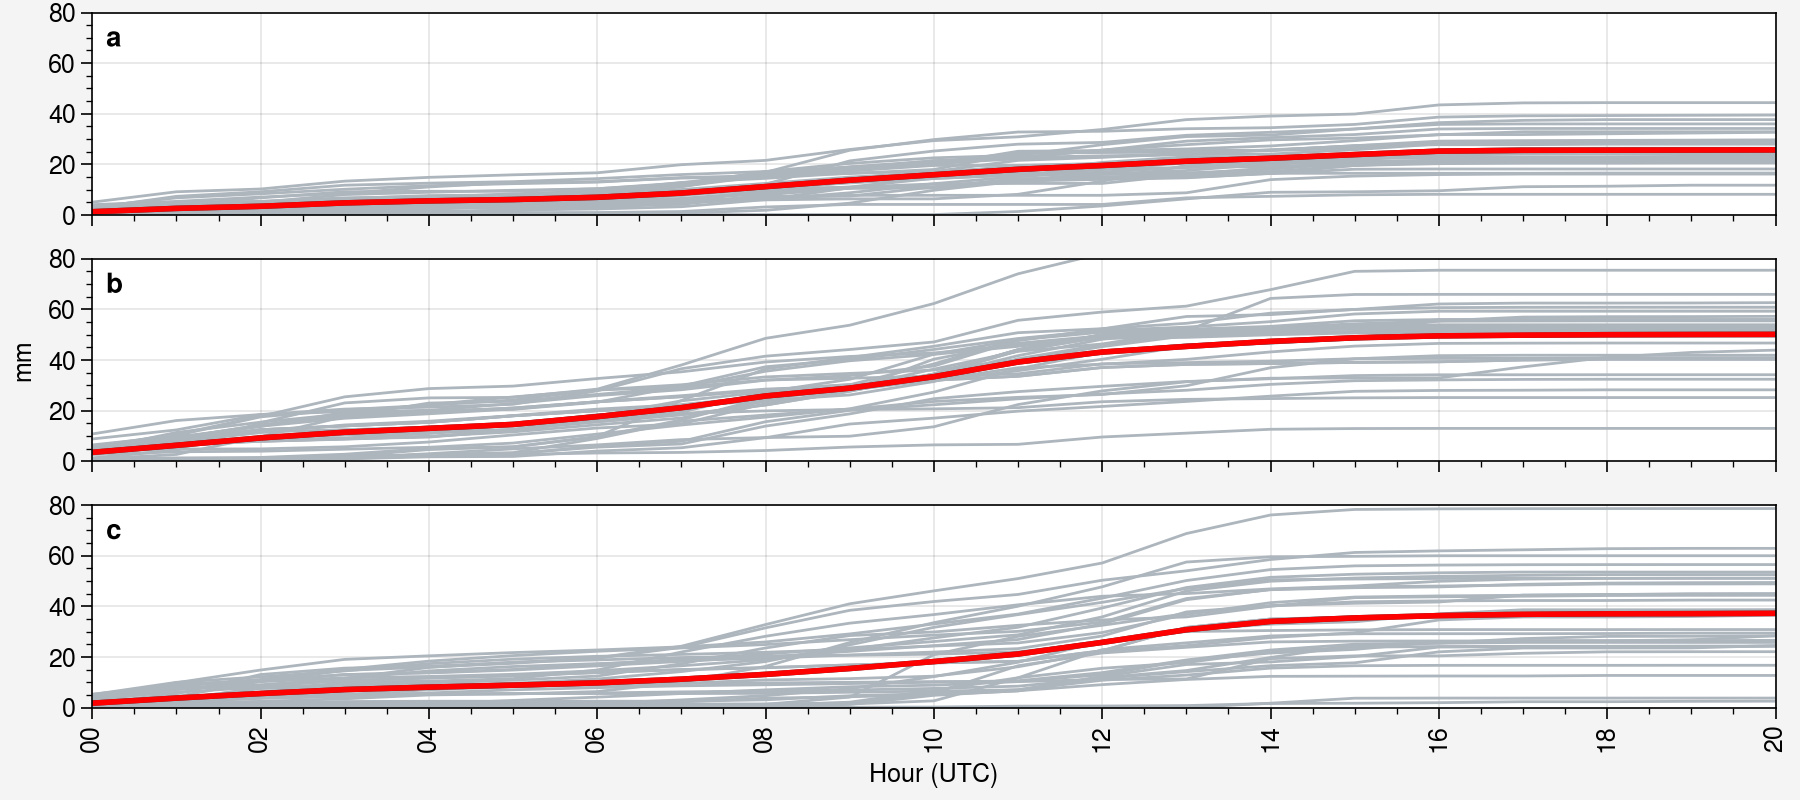

In [84]:
# start figure
f, axs = proplot.subplots(array=[[1, 1, 1, 1],
                                [2, 2, 2, 2],
                                [3, 3, 3, 3], 
                                ], 
                              hratios=(1,), share=4, 
                              hspace=1.75, figsize=(9,4),
                              axwidth=1.5, tight=True)
# format whole figure
axs.format(abcloc='ul',
           abc=True,)

# path effect feature
path_effect = [pe.Stroke(linewidth=2, foreground='#403f3f'),
                    pe.Normal()]
# plot lines
dts = [observation.cumsum(axis=0), imerg_pd.cumsum(axis=0), wrf_pd.cumsum(axis=0)]
dts_mean = [observation_mean, imerg_pd_mean, wrf_pd_mean]

for i in range(3):
    lp = axs[i].plot(dts[i], colors='gray5', lw=1,    
                     )
    lp_mean = axs[i].plot(dts_mean[i], colors='red', lw=2,
                          path_effects=path_effect,
                     )
    axs[i].format(xformatter='%H')

# set ylims
vmin,vmax = 0, 80
for i in range(3):
    axs[i].set_ylim([vmin, vmax])
    axs[i].set_xlabel('Hour (UTC)')  
    axs[i].set_ylabel('mm')      
    
#save figure
plt.savefig(r'pictures/FigureS5.jpeg',
            bbox_inches='tight', optimize=True,
            progressive=True, dpi=1000)

## 6. Scores

In [13]:
dt_urban_single = dt.sel(ens = urban_members)[:, :21, :, :]

In [14]:
dt_urban_single.rio.crs

CRS.from_wkt('PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["unknown",6370000,0]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",39.825008392334],PARAMETER["central_meridian",32.5120010375977],PARAMETER["standard_parallel_1",39.8250007629395],PARAMETER["standard_parallel_2",39.8250007629395],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [15]:
imerg.rio.crs

### 6.1 Set Crs and Dimension

In [16]:
dt_urban_single = dt_urban_single.rio.set_spatial_dims(x_dim='west_east', y_dim='south_north')
imerg = imerg.rio.set_spatial_dims(x_dim='lon', y_dim='lat')

In [17]:
#imerg = imerg.rio.write_crs(pyproj.CRS.from_user_input(4326))
imerg = imerg.rio.write_crs(cartopy.crs.PlateCarree())

In [18]:
imerg.rio.crs

CRS.from_wkt('PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["unknown",ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1,ID["EPSG",9001]]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8901]]],CONVERSION["unknown",METHOD["Equidistant Cylindrical",ID["EPSG",1028]],PARAMETER["Latitude of 1st standard parallel",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8823]],PARAMETER["Longitude of natural origin",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["False easting",0,LENGTHUNIT["unknown",111319.490793274],ID["EPSG",8806]],PARAMETER["False northing",0,LENGTHUNIT["unknown",111319.490793274],ID["EPSG",8807]]],CS[Cartesian,3],AXIS["(E)",east,ORDER[1],LENGTHUNIT["unknown",111319.490793274]],AXIS["(N)",north,ORDER[2],LENGTHUNIT["unknown",111319.490793274]],AXIS["ellipsoidal height (h)",up,ORDER[3],LENGTHUNIT["metre",1,ID["EPSG",9001]]]]')

### 6.2 Interpolate IMERG Data

In [19]:
# interpolation
new_lon = np.linspace(imerg.lon.values[0], imerg.lon.values[-1], len(imerg.lon.values) * 8)
new_lat = np.linspace(imerg.lat.values[0], imerg.lat.values[-1], len(imerg.lat.values) * 8)

imerg_interp = imerg.interp(lat=new_lat, lon=new_lon)

### 6.3 Clip Datasets to Ankara

In [22]:
ankara_shp = geopandas.read_file(r'data/shapefiles/ankara_province_shape.shp')

imerg_clip = imerg_interp.rio.clip(ankara_shp.geometry.apply(mapping),
                    ankara_shp.crs, all_touched=True, 
                    invert=False, from_disk=True)

dt_urban_single_clip = dt_urban_single.rio.clip(ankara_shp.geometry.apply(mapping),
                    ankara_shp.crs, all_touched=True, 
                    invert=False, from_disk=True)

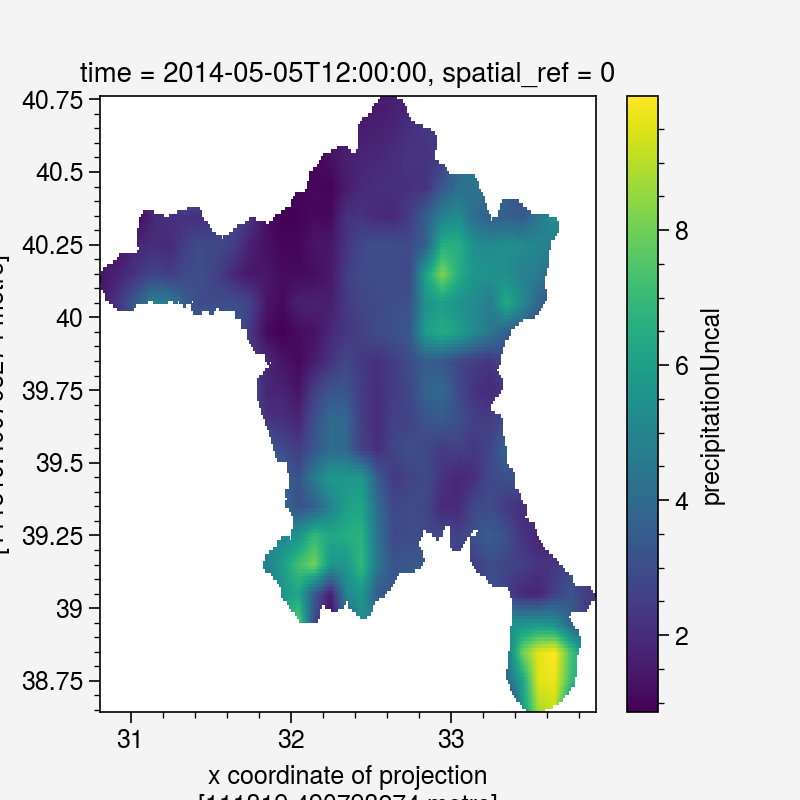

In [25]:
imerg_clip[12].plot()

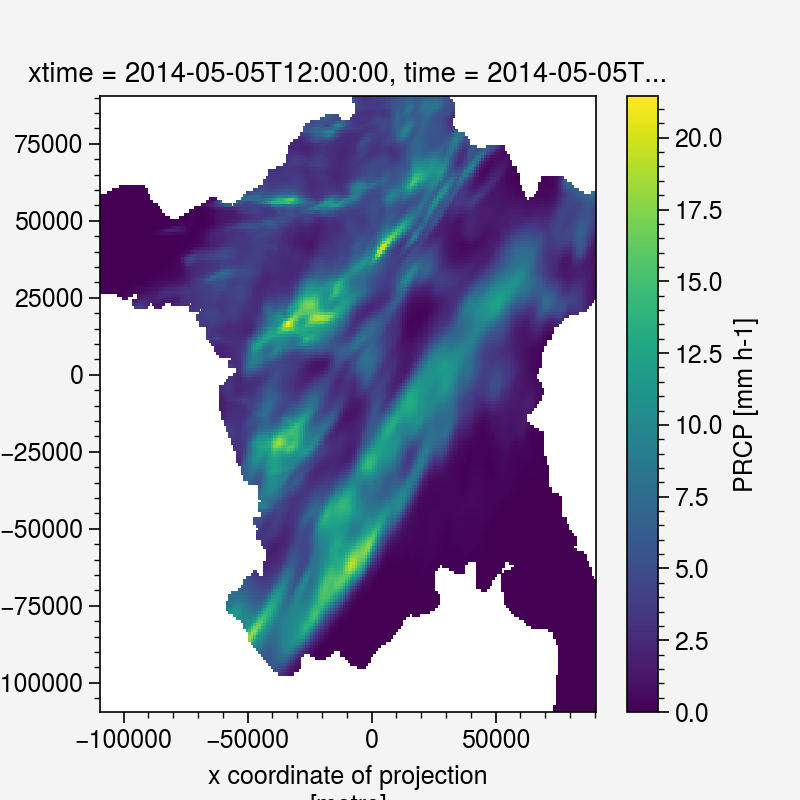

In [24]:
dt_urban_single_clip[0][12].plot()

### 6.4 Rematch Grid

In [26]:
imerg_regrid = imerg_clip.rio.reproject_match(dt_urban_single_clip)

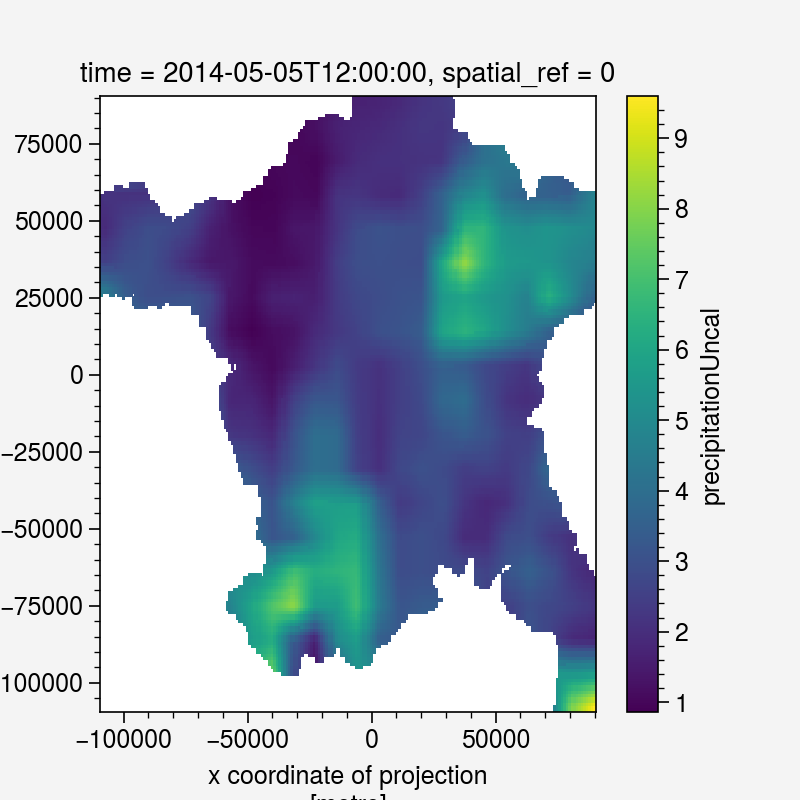

In [28]:
imerg_regrid[12].plot()

### 6.5 Score Calculation

In [29]:
imerg_regrid = imerg_regrid.rename({'y':'south_north',
                     'x':'west_east'})

In [32]:
skill_um_rmse = {}
for um in urban_members:
    skill_um_rmse[um] = xskillscore.rmse(imerg_regrid, 
                     dt_urban_single_clip.sel(ens=um),
                     dim = 'time',
                     skipna = True
                            ).compute().mean()

In [33]:
skill_um_rmse

{'lin_urban_PRCP': <xarray.DataArray ()>
 array(3.0160255, dtype=float32)
 Coordinates:
     spatial_ref  int64 0
     ens          <U14 'lin_urban_PRCP',
 'thompson_urban_PRCP': <xarray.DataArray ()>
 array(2.829118, dtype=float32)
 Coordinates:
     spatial_ref  int64 0
     ens          <U19 'thompson_urban_PRCP',
 'wsm6_urban_PRCP': <xarray.DataArray ()>
 array(2.9537966, dtype=float32)
 Coordinates:
     spatial_ref  int64 0
     ens          <U15 'wsm6_urban_PRCP'}

In [34]:
skill_um_mae = {}
for um in urban_members:
    skill_um_mae[um] = xskillscore.mae(imerg_regrid, 
                     dt_urban_single_clip.sel(ens=um),
                     dim = 'time',
                     skipna = True
                            ).compute().mean()

In [35]:
skill_um_mae

{'lin_urban_PRCP': <xarray.DataArray ()>
 array(2.0560155, dtype=float32)
 Coordinates:
     spatial_ref  int64 0
     ens          <U14 'lin_urban_PRCP',
 'thompson_urban_PRCP': <xarray.DataArray ()>
 array(1.9707546, dtype=float32)
 Coordinates:
     spatial_ref  int64 0
     ens          <U19 'thompson_urban_PRCP',
 'wsm6_urban_PRCP': <xarray.DataArray ()>
 array(2.005752, dtype=float32)
 Coordinates:
     spatial_ref  int64 0
     ens          <U15 'wsm6_urban_PRCP'}